In [1]:
# all imports
from necessary_functions import get_numtadb_training_data
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Data Loading

In [2]:
# the first layer of AlexNet intakes a 227x227 image.
# causes memory error, so just let's load these as 32x32 images and later we will add a resize layer to our model

images, labels = get_numtadb_training_data(
    dataset_directory="NumtaDB_Bengali Handwritten Digits/", img_resize_size=(32, 32), img_fmt='color'
)

Dataset Loading is Complete


In [3]:
# total number of images
print(len(images), len(labels))

72045 72045


In [4]:
np.random.seed(7)
# generate indices for masking and shuffling them
index = list(range(len(labels)))
np.random.shuffle(index)

In [5]:
# now we will take 80% of the data as train set and 20% as test set
train_amount = int(len(labels)*0.8)
X_train = images[index[:train_amount]]
X_test = images[index[train_amount:]]
y_train = labels[index[:train_amount]]
y_test = labels[index[train_amount:]]

The corresponding label is 5


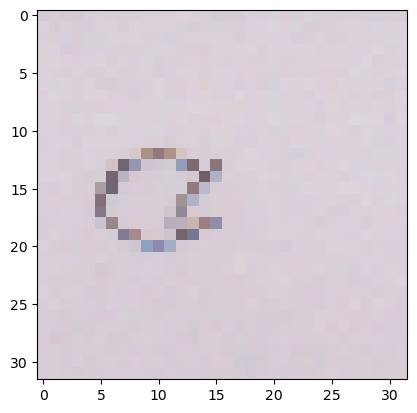

In [6]:
# sanity check 1
plt.imshow(X_train[57], 'gray')
print(f"The corresponding label is {y_train[57]}")

In [7]:
# sanity check 2
print(f"Size of training data are {len(X_train)} and {len(y_train)}")
print(f"Size of testing data are {len(X_test)} and {len(y_test)}")

Size of training data are 57636 and 57636
Size of testing data are 14409 and 14409


# AlexNet Model Definition

![AlexNet Architecture](AlexNet-1-1430805382.png)

The above figure shows the AlexNet Architecture and we are going to implement it using tensorflow. Aside from the layers shown in the figure the authors mentions in the paper that the output from all the layers are followed by 'relu' activation function and there are local response normalization layers following the first two 'relu'.

In [8]:
# using functional api
def alexnet(input_shape):
    input_img = tf.keras.layers.Input(input_shape)
    img_resized = tf.keras.layers.Resizing(227,227)(input_img) # resizing before passing to the first convolutional layer
    
    C1 = tf.keras.layers.Conv2D(filters = 96, kernel_size = 11, strides = 4, padding = 'valid')(img_resized)
    A1 = tf.keras.layers.Activation('relu')(C1)
    LRN1 = tf.keras.layers.Lambda(tf.nn.local_response_normalization)(A1)
    P1 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2)(LRN1)
    
    C2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 5, strides = 1, padding = 'same')(P1)
    A2 = tf.keras.layers.Activation('relu')(C2)
    LRN2 = tf.keras.layers.Lambda(tf.nn.local_response_normalization)(A2)
    P2 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2)(LRN2)
    
    C3 = tf.keras.layers.Conv2D(filters = 384, kernel_size = 3, strides = 1, padding = 'same')(P2)
    A3 = tf.keras.layers.Activation('relu')(C3)
    C4 = tf.keras.layers.Conv2D(filters = 384, kernel_size = 3, strides = 1, padding = 'same')(A3)
    A4 = tf.keras.layers.Activation('relu')(C4)
    C5 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same')(A4)
    A5 = tf.keras.layers.Activation('relu')(C5)
    
    P3 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2)(A5)
    
    P3_flattened = tf.keras.layers.Flatten()(P3)
    FC1 = tf.keras.layers.Dense(4096, activation='relu')(P3_flattened)
    FC2 = tf.keras.layers.Dense(4096, activation='relu')(FC1)
    output = tf.keras.layers.Dense(10, activation='softmax')(FC2) # 10 neurons as there are only 10 classes
    
    AlexNet = tf.keras.Model(inputs=input_img, outputs=output)
    return AlexNet

In [9]:
AlexNet = alexnet(input_shape=(32,32,3))
AlexNet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 227, 227, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 lambda (Lambda)             (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                             

# Model Training

In [10]:
AlexNet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

with tf.device('/CPU:0'):
    history = AlexNet.fit(
        X_train, y_train, validation_split=0.2, epochs=10, batch_size=64,
    )  # and 20% of training data is used as validation set

Epoch 1/10
721/721 [==============================] - 1371s 2s/step - loss: 1.9452 - accuracy: 0.2648 - val_loss: 1.8175 - val_accuracy: 0.2933
Epoch 2/10
721/721 [==============================] - 1365s 2s/step - loss: 1.8181 - accuracy: 0.2933 - val_loss: 1.8124 - val_accuracy: 0.2936
Epoch 3/10
721/721 [==============================] - 1358s 2s/step - loss: 1.8065 - accuracy: 0.2962 - val_loss: 1.8140 - val_accuracy: 0.2916
Epoch 4/10
721/721 [==============================] - 1351s 2s/step - loss: 1.7950 - accuracy: 0.3008 - val_loss: 1.8056 - val_accuracy: 0.2946
Epoch 5/10
721/721 [==============================] - 1346s 2s/step - loss: 1.7907 - accuracy: 0.3021 - val_loss: 1.8102 - val_accuracy: 0.2963
Epoch 6/10
721/721 [==============================] - 1352s 2s/step - loss: 1.7898 - accuracy: 0.3034 - val_loss: 1.8137 - val_accuracy: 0.2938
Epoch 7/10
721/721 [==============================] - 1363s 2s/step - loss: 1.7899 - accuracy: 0.3034 - val_loss: 1.7980 - val_accuracy:

In [11]:
AlexNet.evaluate(X_test, y_test)

451/451 [==============================] - 17s 32ms/step - loss: 1.8067 - accuracy: 0.3031


[1.806747317314148, 0.3030744791030884]

# Checking performance on mnist dataset

lets check with a standard dataset namely mnist dataset and compare the results

In [2]:
# using functional api
def alexnet(input_shape):
    input_img = tf.keras.layers.Input(input_shape)
    img_resized = tf.keras.layers.Resizing(227,227)(input_img) # resizing before passing to the first convolutional layer
    
    C1 = tf.keras.layers.Conv2D(filters = 96, kernel_size = 11, strides = 4, padding = 'valid')(img_resized)
    A1 = tf.keras.layers.Activation('relu')(C1)
    LRN1 = tf.keras.layers.Lambda(tf.nn.local_response_normalization)(A1)
    P1 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2)(LRN1)
    
    C2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 5, strides = 1, padding = 'same')(P1)
    A2 = tf.keras.layers.Activation('relu')(C2)
    LRN2 = tf.keras.layers.Lambda(tf.nn.local_response_normalization)(A2)
    P2 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2)(LRN2)
    
    C3 = tf.keras.layers.Conv2D(filters = 384, kernel_size = 3, strides = 1, padding = 'same')(P2)
    A3 = tf.keras.layers.Activation('relu')(C3)
    C4 = tf.keras.layers.Conv2D(filters = 384, kernel_size = 3, strides = 1, padding = 'same')(A3)
    A4 = tf.keras.layers.Activation('relu')(C4)
    C5 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same')(A4)
    A5 = tf.keras.layers.Activation('relu')(C5)
    
    P3 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2)(A5)
    
    P3_flattened = tf.keras.layers.Flatten()(P3)
    FC1 = tf.keras.layers.Dense(4096, activation='relu')(P3_flattened)
    FC2 = tf.keras.layers.Dense(4096, activation='relu')(FC1)
    output = tf.keras.layers.Dense(10, activation='softmax')(FC2) # 10 neurons as there are only 10 classes
    
    AlexNet = tf.keras.Model(inputs=input_img, outputs=output)
    return AlexNet

In [3]:
AlexNet = alexnet(input_shape=(28,28,1))
AlexNet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 resizing (Resizing)         (None, 227, 227, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        11712     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 lambda (Lambda)             (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                             

In [4]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
AlexNet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

with tf.device('/CPU:0'):
    history2 = AlexNet.fit(
        X_train, y_train, validation_split=0.2, epochs=10, batch_size=64,
    )  # and 20% of training data is used as validation set

Epoch 1/10
750/750 [==============================] - 1494s 2s/step - loss: 0.2779 - accuracy: 0.9240 - val_loss: 0.0725 - val_accuracy: 0.9796
Epoch 2/10
750/750 [==============================] - 1472s 2s/step - loss: 0.0650 - accuracy: 0.9802 - val_loss: 0.0616 - val_accuracy: 0.9831
Epoch 3/10
750/750 [==============================] - 1541s 2s/step - loss: 0.0585 - accuracy: 0.9833 - val_loss: 0.0578 - val_accuracy: 0.9834
Epoch 4/10
750/750 [==============================] - 1403s 2s/step - loss: 0.0453 - accuracy: 0.9868 - val_loss: 0.0580 - val_accuracy: 0.9877
Epoch 5/10
750/750 [==============================] - 1355s 2s/step - loss: 0.0382 - accuracy: 0.9890 - val_loss: 0.0428 - val_accuracy: 0.9876
Epoch 6/10
750/750 [==============================] - 1337s 2s/step - loss: 0.0380 - accuracy: 0.9891 - val_loss: 0.0523 - val_accuracy: 0.9865
Epoch 7/10
750/750 [==============================] - 1342s 2s/step - loss: 0.0297 - accuracy: 0.9913 - val_loss: 0.0392 - val_accuracy:

In [5]:
AlexNet.evaluate(X_test, y_test)

313/313 [==============================] - 14s 30ms/step - loss: 0.0489 - accuracy: 0.9883


[0.04892425611615181, 0.9883000254631042]

The training is very slow on cpu but as gpu memory is also less (4GB) so training for higher number of epochs is not possible. Also it seems that the model works better for mnist dataset than the bengali handwritten digit dataset. it could be due to grayscaling of image. Let's check for this hypothesis next

# Checking performance on grayscaled bengali handwritten digits dataset

Also lets use Batchnormalization instead of LRN. as mentioned in https://medium.com/swlh/alexnet-with-tensorflow-46f366559ce8 LRN slows down the implementation and does not significantly contribute towards accuracy. Also we will modify the main base architecture by modifying the number of input channels to each layer. This will be done to reduce the number of parameters that needs to be learned. Current implementation has about 58.32M parameters. 

In [2]:
# the first layer of AlexNet intakes a 227x227 image.
# causes memory error, so just let's load these as 32x32 images and later we will add a resize layer to our model

images, labels = get_numtadb_training_data(
    dataset_directory="NumtaDB_Bengali Handwritten Digits/", img_resize_size=(28, 28), img_fmt='grayscale'
)

np.random.seed(7)
# generate indices for masking and shuffling them
index = list(range(len(labels)))
np.random.shuffle(index)

# now we will take 80% of the data as train set and 20% as test set
train_amount = int(len(labels)*0.8)
X_train = images[index[:train_amount]]
X_test = images[index[train_amount:]]
y_train = labels[index[:train_amount]]
y_test = labels[index[train_amount:]]

Dataset Loading is Complete


In [3]:
# using functional api
def alexnet(input_shape):
    input_img = tf.keras.layers.Input(input_shape)
    img_resized = tf.keras.layers.Resizing(227,227)(input_img) # resizing before passing to the first convolutional layer
    
    C1 = tf.keras.layers.Conv2D(filters = 96, kernel_size = 11, strides = 4, padding = 'valid')(img_resized)
    A1 = tf.keras.layers.Activation('relu')(C1)
    LRN1 = tf.keras.layers.Lambda(tf.nn.local_response_normalization)(A1)
    P1 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2)(LRN1)
    
    C2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 5, strides = 1, padding = 'same')(P1)
    A2 = tf.keras.layers.Activation('relu')(C2)
    LRN2 = tf.keras.layers.Lambda(tf.nn.local_response_normalization)(A2)
    P2 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2)(LRN2)
    
    C3 = tf.keras.layers.Conv2D(filters = 384, kernel_size = 3, strides = 1, padding = 'same')(P2)
    A3 = tf.keras.layers.Activation('relu')(C3)
    C4 = tf.keras.layers.Conv2D(filters = 384, kernel_size = 3, strides = 1, padding = 'same')(A3)
    A4 = tf.keras.layers.Activation('relu')(C4)
    C5 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same')(A4)
    A5 = tf.keras.layers.Activation('relu')(C5)
    
    P3 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2)(A5)
    
    P3_flattened = tf.keras.layers.Flatten()(P3)
    FC1 = tf.keras.layers.Dense(4096, activation='relu')(P3_flattened)
    FC2 = tf.keras.layers.Dense(4096, activation='relu')(FC1)
    output = tf.keras.layers.Dense(10, activation='softmax')(FC2) # 10 neurons as there are only 10 classes
    
    AlexNet = tf.keras.Model(inputs=input_img, outputs=output)
    return AlexNet

In [4]:
AlexNet = alexnet(input_shape=(28,28,1))
AlexNet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 resizing (Resizing)         (None, 227, 227, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        11712     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 lambda (Lambda)             (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                             

In [5]:
AlexNet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

with tf.device('/CPU:0'):
    history3 = AlexNet.fit(
        X_train, y_train, validation_split=0.2, epochs=10, batch_size=64,
    )  # and 20% of training data is used as validation set

Epoch 1/10
689/721 [===========================>..] - ETA: 52s - loss: 1.9283 - accuracy: 0.2575

KeyboardInterrupt: 

Doesn't seem to improve.